In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
# df_path = "../../data/raw/hedges-all.tsv"
# df_path = "../../data/raw/studytype_multiclass.tsv"
df = pd.read_csv(df_path, sep="\t")
# PERFORM DATA PROCESSING (LEMATIZATION ETC), GET TFIDF SCORES AND FEATURE NAMES.
# COULD be parallelised

from eppi_text_classification import (
    get_features,
    get_labels,
    get_tfidf_and_names,
)

word_features = get_features(
    df,
    # title_key="ti",
    # abstract_key="ab",
    # title_key="TI",
    # abstract_key="AB",
)

labels = get_labels(
    df,
    # label_column_name="is_rct",
    # positive_class_value="1",
    # label_column_name="Class",
    # positive_class_value="CaseControlStudies",
)
tfidf_scores, feature_names = get_tfidf_and_names(word_features)

number of processes: 12
number of processes: 12


In [13]:
from eppi_text_classification import OptunaHyperparameterOptimisation

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "RandomForestClassifier",
    max_n_search_iterations=10,
    n_jobs=1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
    user_selected_hyperparameter_ranges={
        "bootstrap": {"value": False, "suggest_type": "singular"},
        "oob_score": {"value": True, "suggest_type": "singular"},
    },
)

optimiser.delete_optuna_study("random_forest_binary")
best_params = optimiser.optimise_hyperparameters(study_name="random_forest_binary")

[I 2025-01-27 13:05:42,224] A new study created in RDB with name: random_forest_binary


Number of processes: 1
sqlite:////Users/sjmolyneux/Documents/EPPI_Classification_Public/eppi_text_classification/optuna.db
{'max_samples': {'value': None, 'suggest_type': 'singular'}, 'max_depth': {'value': None, 'suggest_type': 'singular'}, 'ccp_alpha': {'value': 0, 'suggest_type': 'singular'}, 'min_samples_leaf': {'value': 1, 'suggest_type': 'singular'}, 'min_samples_split': {'value': 2, 'suggest_type': 'singular'}, 'max_features': {'value': 'sqrt', 'suggest_type': 'singular'}, 'monotonic_cst': {'value': None, 'suggest_type': 'singular'}, 'bootstrap': {'value': False, 'suggest_type': 'singular'}, 'min_weight_fraction_leaf': {'value': 0, 'suggest_type': 'singular'}, 'oob_score': {'value': True, 'suggest_type': 'singular'}, 'n_estimators': {'low': 100, 'high': 1000, 'log': False, 'suggest_type': 'int'}, 'criterion': {'value': 'gini', 'suggest_type': 'singular'}, 'max_leaf_nodes': {'value': None, 'suggest_type': 'singular'}, 'min_impurity_decrease': {'value': 0, 'suggest_type': 'singula

[I 2025-01-27 13:05:44,816] Trial 0 finished with value: 0.9411422728419415 and parameters: {'n_estimators': 674}. Best is trial 0 with value: 0.9411422728419415.


Finished trial with scores: [0.9280964256026599, 0.9394846217788861, 0.9558457711442785]


[I 2025-01-27 13:05:45,350] Trial 1 finished with value: 0.927420078091906 and parameters: {'n_estimators': 135}. Best is trial 0 with value: 0.9411422728419415.


Finished trial with scores: [0.9239401496259352, 0.9208645054031588, 0.937455579246624]


[I 2025-01-27 13:05:48,415] Trial 2 finished with value: 0.9436862268635448 and parameters: {'n_estimators': 816}. Best is trial 2 with value: 0.9436862268635448.


Finished trial with scores: [0.9226101413133831, 0.9605985037406484, 0.9478500355366027]


[I 2025-01-27 13:05:51,810] Trial 3 finished with value: 0.9447402430904498 and parameters: {'n_estimators': 899}. Best is trial 3 with value: 0.9447402430904498.


Finished trial with scores: [0.9204488778054863, 0.9529509559434746, 0.960820895522388]


[I 2025-01-27 13:05:55,734] Trial 4 finished with value: 0.9428063636218621 and parameters: {'n_estimators': 989}. Best is trial 3 with value: 0.9447402430904498.


Finished trial with scores: [0.9221945137157107, 0.945137157107232, 0.9610874200426439]


[I 2025-01-27 13:05:57,809] Trial 5 finished with value: 0.9386743104333456 and parameters: {'n_estimators': 553}. Best is trial 3 with value: 0.9447402430904498.


Finished trial with scores: [0.930590191188695, 0.9296758104738154, 0.9557569296375266]


[I 2025-01-27 13:05:59,099] Trial 6 finished with value: 0.9414845231153341 and parameters: {'n_estimators': 327}. Best is trial 3 with value: 0.9447402430904498.


Finished trial with scores: [0.9083125519534497, 0.9482128013300082, 0.9679282160625443]


[I 2025-01-27 13:06:01,464] Trial 7 finished with value: 0.9379246003683045 and parameters: {'n_estimators': 624}. Best is trial 3 with value: 0.9447402430904498.


Finished trial with scores: [0.9118869492934332, 0.9513715710723192, 0.9505152807391613]


[I 2025-01-27 13:06:05,023] Trial 8 finished with value: 0.9380461574091306 and parameters: {'n_estimators': 949}. Best is trial 3 with value: 0.9447402430904498.


Finished trial with scores: [0.9201995012468828, 0.9467996674979219, 0.9471393034825871]


[I 2025-01-27 13:06:05,801] Trial 9 finished with value: 0.9228532406250425 and parameters: {'n_estimators': 197}. Best is trial 3 with value: 0.9447402430904498.


Finished trial with scores: [0.9078137988362427, 0.912718204488778, 0.9480277185501065]


In [3]:
# FIT THE MODEL

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# model = RandomForestClassifier(**best_params)

model = RandomForestClassifier(class_weight={1: 32}, n_estimators=1000, bootstrap=False, n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=8
)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={1: 32}, n_estimators=1000,
                       n_jobs=-1)

In [4]:
# CREATE ROC CURVE TO SELECT THRESHOLD

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

In [15]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(model, tfidf_scores, labels, return_times=True)

for thing in zip(train_sizes, train_scores, test_scores, fit_times, score_times):
    print(thing)

(3922, array([0.99974503, 1.        , 1.        , 1.        , 1.        ]), array([0.8536461 , 0.97317695, 0.96868944, 0.98531362, 0.98684345]), array([45.92960691, 36.44522524, 36.75345612, 41.58079314, 43.21682572]), array([3.05901909, 2.67308974, 2.65672088, 2.37465191, 2.60072231]))
(12746, array([0.99984309, 0.99992154, 0.99992154, 1.        , 0.99992154]), array([0.95318715, 0.9809281 , 0.97470678, 0.98103009, 0.96970933]), array([76.56762886, 82.38365388, 82.30012918, 84.11257887, 84.11392379]), array([2.7872622 , 2.5551281 , 2.78449297, 2.70038199, 3.1010282 ]))
(21571, array([0.99995364, 0.99995364, 0.99935098, 1.        , 0.99986092]), array([0.96532381, 0.97735849, 0.97338093, 0.97715451, 0.96644569]), array([118.06064606, 113.56281996, 132.62477088, 133.747082  ,
       130.86591101]), array([2.76622009, 2.63950396, 2.82435822, 2.55296707, 3.15363884]))
(30395, array([0.9998355, 0.9999671, 0.9998355, 1.       , 0.9999671]), array([0.96664967, 0.97582866, 0.97562468, 0.97480

Trees: 10, Validation Score: 0.7885
Trees: 60, Validation Score: 0.9460
Trees: 110, Validation Score: 0.9426
Trees: 160, Validation Score: 0.9376
Trees: 210, Validation Score: 0.9770
Trees: 260, Validation Score: 0.9619
Trees: 310, Validation Score: 0.9730
Trees: 360, Validation Score: 0.9637
Trees: 410, Validation Score: 0.9701
Trees: 460, Validation Score: 0.9759
Trees: 510, Validation Score: 0.9570
Trees: 560, Validation Score: 0.9723
Trees: 610, Validation Score: 0.9684
Trees: 660, Validation Score: 0.9696
Trees: 710, Validation Score: 0.9626
Trees: 760, Validation Score: 0.9766
Trees: 810, Validation Score: 0.9708
Trees: 860, Validation Score: 0.9713
Trees: 910, Validation Score: 0.9687
Trees: 960, Validation Score: 0.9672


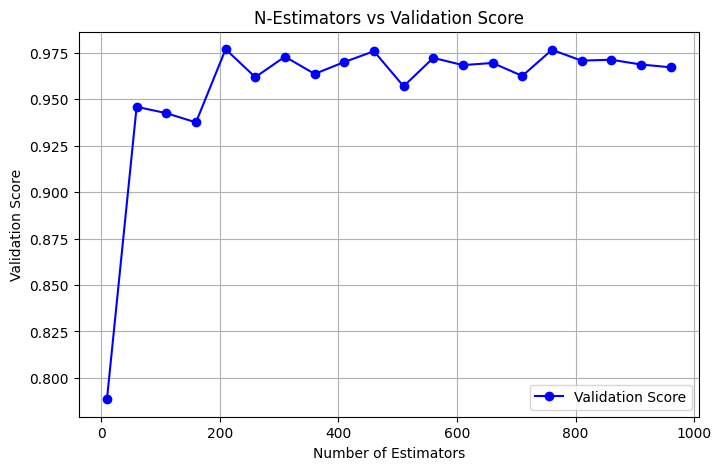

In [8]:
import matplotlib.pyplot as plt    
import numpy as np
from sklearn.metrics import roc_auc_score

# Define the range of estimators
n_estimators_list = np.arange(10, 1001, 50)  # From 10 to 200 in steps of 10
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, class_weight={1: 32}, bootstrap=False)
scores = []
for n in n_estimators_list:

    rf.set_params(n_estimators=n)  # Set the number of estimators
    rf.fit(X_train, y_train)  # Continue training

    # Compute validation score
    val_preds =  predict_scores(rf, X_test)
    val_score = roc_auc_score(y_test, val_preds)
    scores.append(val_score)

    print(f"Trees: {n}, Validation Score: {val_score:.4f}")

# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, scores, marker="o", linestyle="-", color="b", label="Validation Score")
plt.xlabel("Number of Estimators")
plt.ylabel("Validation Score")
plt.title("N-Estimators vs Validation Score")
plt.legend()
plt.grid(True)
plt.show()

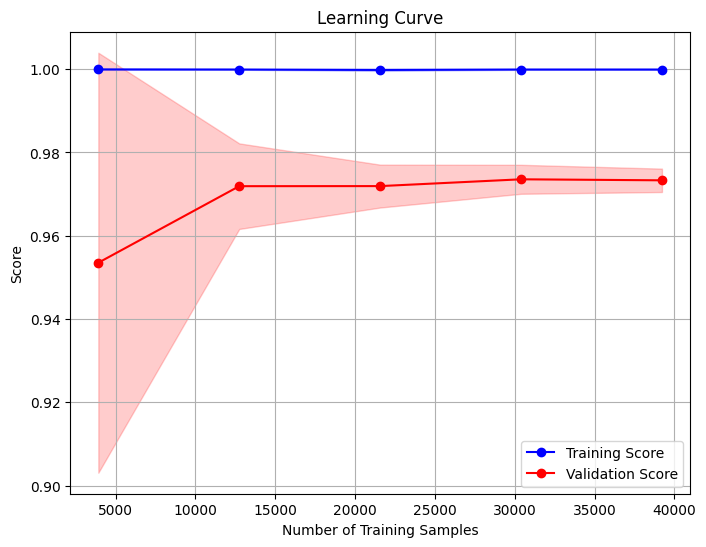

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", marker='o', color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)

plt.plot(train_sizes, test_mean, label="Validation Score", marker='o', color="red")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="red", alpha=0.2)

plt.xlabel("Number of Training Samples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()


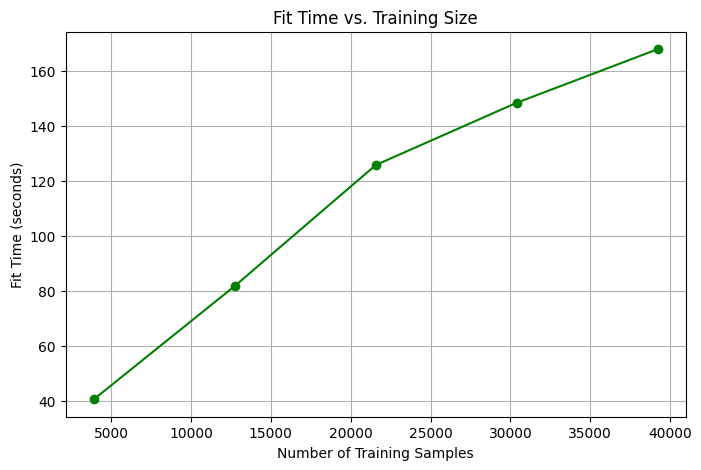

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, fit_times.mean(axis=1), marker='o', color="green")
plt.xlabel("Number of Training Samples")
plt.ylabel("Fit Time (seconds)")
plt.title("Fit Time vs. Training Size")
plt.grid()
plt.show()


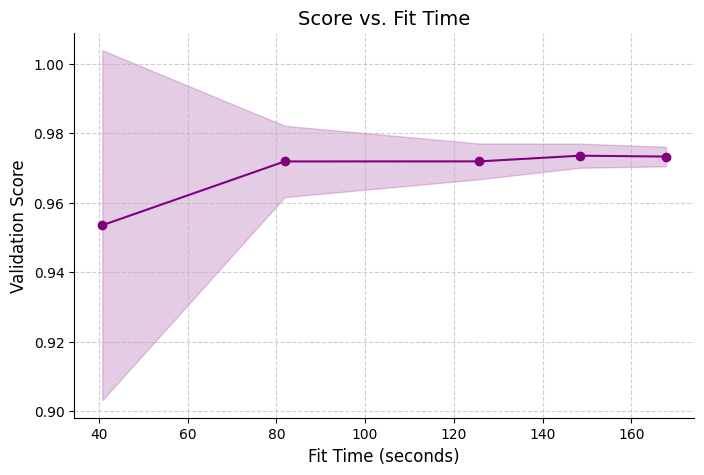

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(np.mean(fit_times, axis=1), test_mean, marker='o', linestyle='-', color="purple", label="Validation Score")
ax.fill_between(np.mean(fit_times, axis=1), test_mean - test_std, test_mean + test_std, color="purple", alpha=0.2)

ax.set_xlabel("Fit Time (seconds)", fontsize=12)
ax.set_ylabel("Validation Score", fontsize=12)
ax.set_title("Score vs. Fit Time", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)
sns.despine()
plt.show()


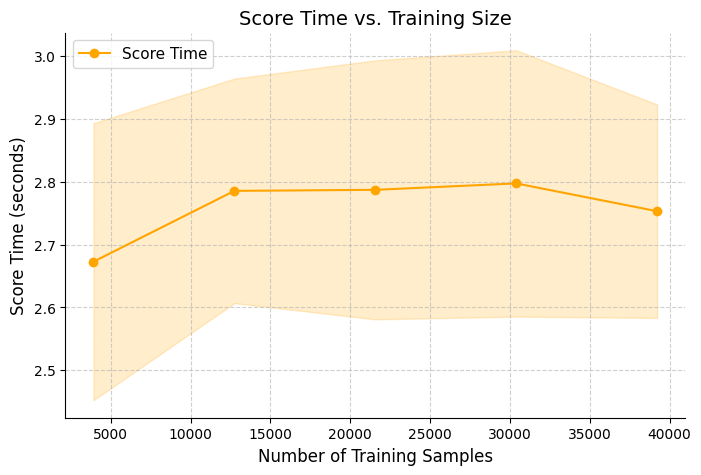

In [19]:
score_mean = np.mean(score_times, axis=1)
score_std = np.std(score_times, axis=1)

# Plot Score Time vs Number of Samples
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(train_sizes, score_mean, marker='o', linestyle='-', color="orange", label="Score Time")
ax.fill_between(train_sizes, score_mean - score_std, score_mean + score_std, color="orange", alpha=0.2)

ax.set_xlabel("Number of Training Samples", fontsize=12)
ax.set_ylabel("Score Time (seconds)", fontsize=12)
ax.set_title("Score Time vs. Training Size", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="best", fontsize=11)
sns.despine()

plt.show()

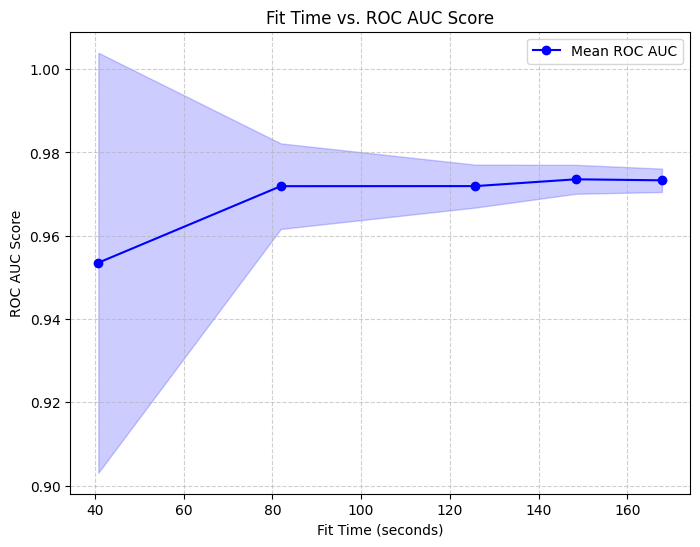

In [20]:
mean_fit_times = np.mean(fit_times, axis=1)
mean_roc_scores = np.mean(test_scores, axis=1)
std_roc_scores = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(mean_fit_times, mean_roc_scores, marker='o', linestyle='-', color='b', label='Mean ROC AUC')
plt.fill_between(mean_fit_times, mean_roc_scores - std_roc_scores, mean_roc_scores + std_roc_scores, color='b', alpha=0.2)

plt.xlabel("Fit Time (seconds)")
plt.ylabel("ROC AUC Score")
plt.title("Fit Time vs. ROC AUC Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [5]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)


threshold = get_raw_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [6]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

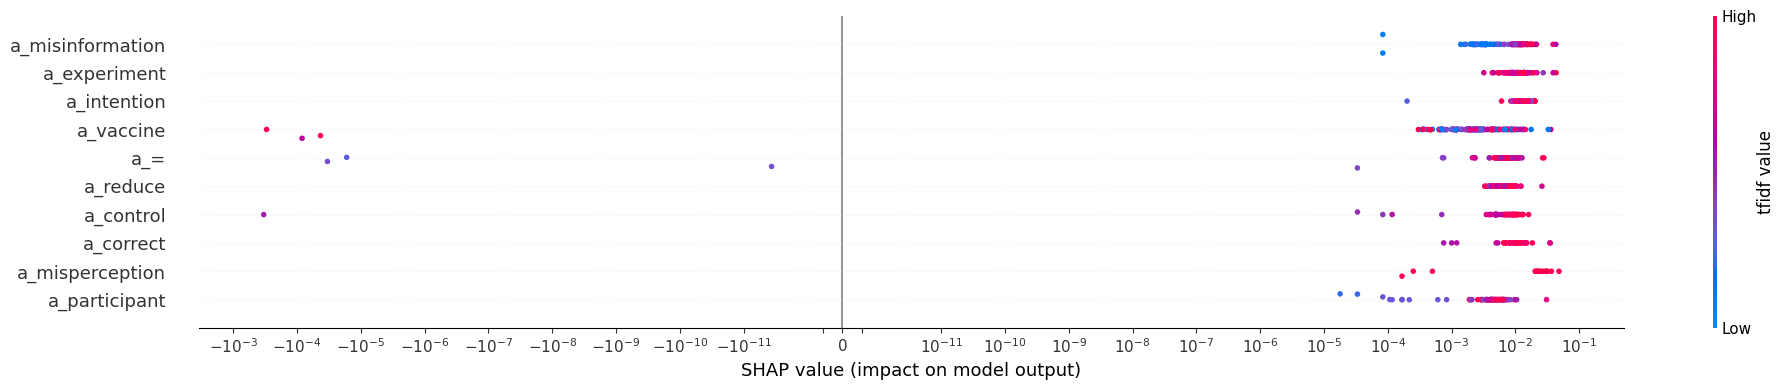

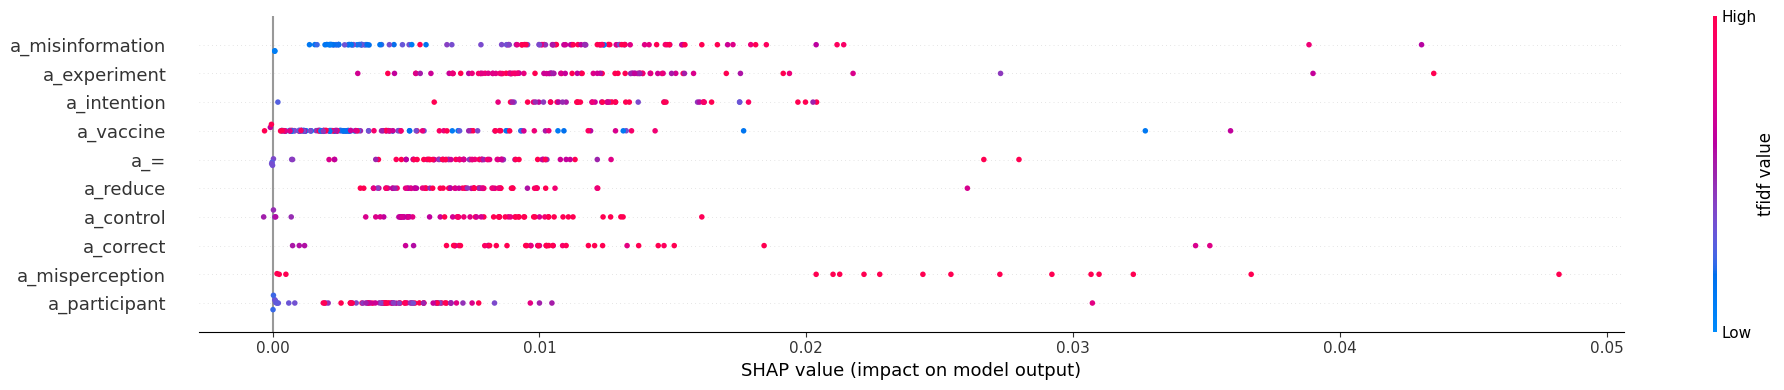

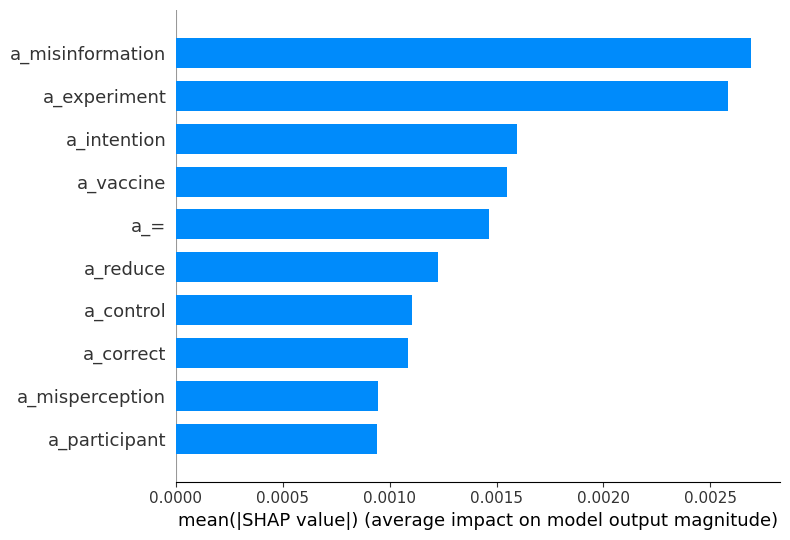

In [7]:
# EXLPAIN THE MODEL

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test, feature_names)

dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()
bar_plot.show()

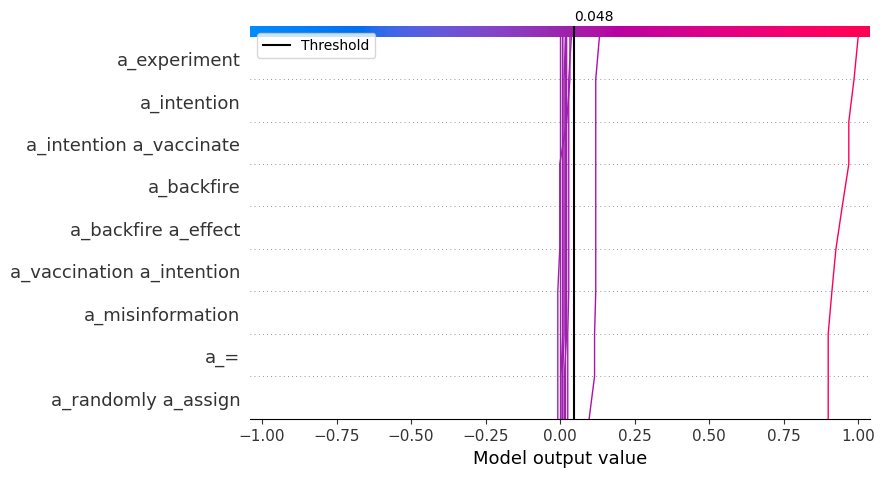

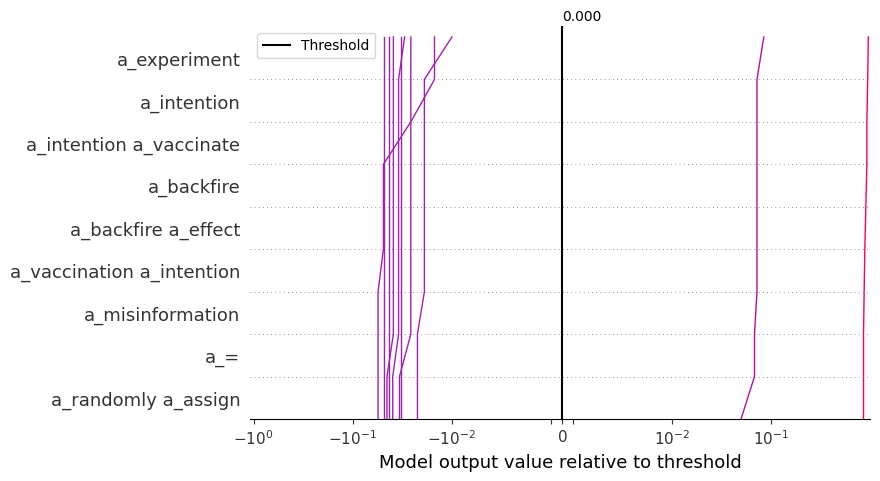

In [8]:
# MAKE THE DECISION PLOTS

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test[:10], feature_names)

decision_plot = shap_plotter.decision_plot(threshold=threshold, num_display=10)
decision_plot.show()
decision_plot = shap_plotter.decision_plot(
    threshold=threshold, num_display=10, log_scale=True
)
decision_plot.show()

Truth: 0
Prediction: [0]
Shap value: 0.03800000179398921
Prediction score: [0.038]


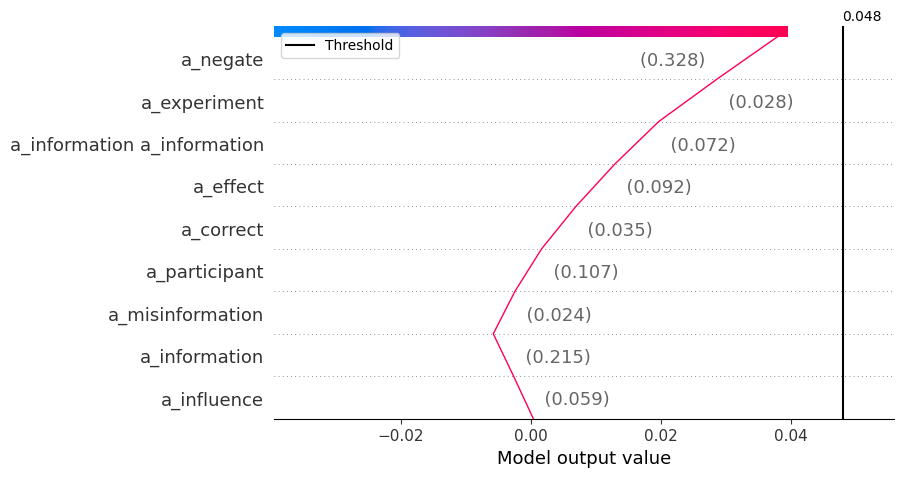

Truth: 0
Prediction: [1]
Shap value: 0.13200000641700171
Prediction score: [0.132]


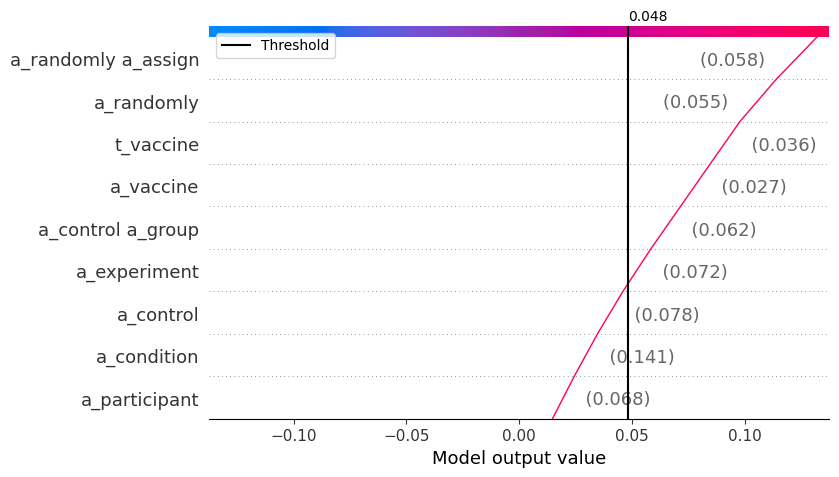

Truth: 0
Prediction: [0]
Shap value: 0.0
Prediction score: [0.]


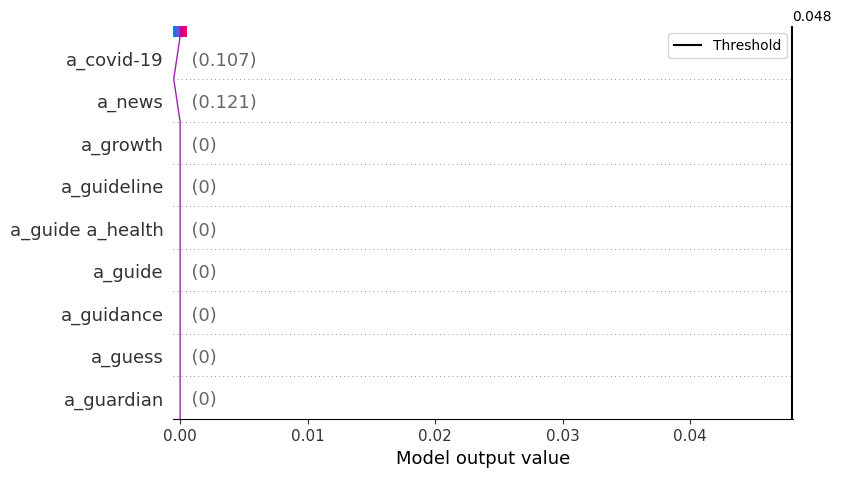

Truth: 0
Prediction: [0]
Shap value: 0.005000000230211299
Prediction score: [0.005]


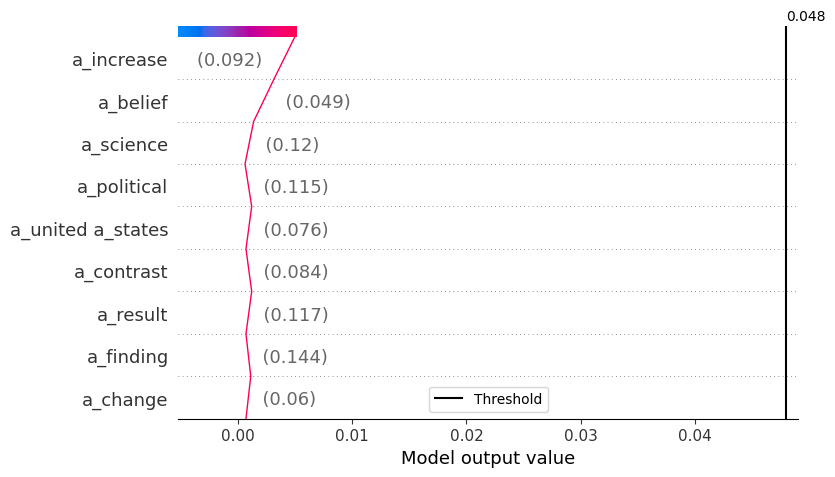

Truth: 0
Prediction: [0]
Shap value: 0.02200000107404776
Prediction score: [0.022]


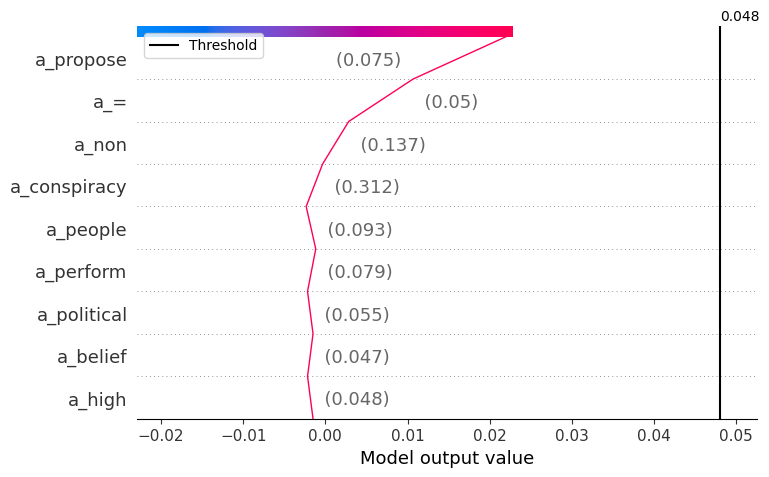

In [9]:
import numpy as np

shap_plotter = ShapPlotter(model, X_test[0:10], feature_names)

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(f"Prediction: {raw_threshold_predict(model, X_test[i], threshold)}")
    print(
        f"Shap value: {shap_plotter.shap_values[i].sum() + shap_plotter.expected_value}"
    )
    print(f"Prediction score: {predict_scores(model, X_test[i])}")
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()